In [2]:
# yahoo finance 패키지 설치
!pip install yfinance --quiet

DEPRECATION: Loading egg at c:\users\gjm10\appdata\local\programs\python\python311\lib\site-packages\tpqoa-0.0.56-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

## 데이터셋 준비 -> 티커 부분 민준햄 껄로 다시 적용시켜보기

* KODEX 200: 069500.KS
* TIGER 코스닥150: 232080.KS
* TIGER 미국S&P 500선물(H): 143850.KS
* TIGER 유로스탁스50(합성, H): 195930.KS
* ACE 일본 Nikkei225(H): 271050.KS
* TIGER 차이나CSI300: 192090.KS

In [4]:
# 자산의 티커
tickers = ['069500.KS', '232080.KS', '143850.KS', '195930.KS', '271050.KS', '192090.KS']

# 데이터 다운로드 (주간 종가 기준)
etf = yf.Tickers(tickers)
data = etf.history(start='2023-06-16', actions=False) # 1년

# 데이터 전처리
data = data['Close']  # 'Close' 컬럼만 사용
data = data.resample('W').last()  # 주간 데이터로 변환

[*********************100%%**********************]  6 of 6 completed


In [5]:
# 주간 수익률 계산
rets = data.pct_change().dropna()
print(rets)

            069500.KS  143850.KS  192090.KS  195930.KS  232080.KS  271050.KS
Date                                                                        
2023-06-25  -0.018816  -0.014660  -0.027912  -0.019094  -0.018005   0.030888
2023-07-02   0.001918   0.008188   0.014357   0.016496  -0.005867  -0.017790
2023-07-09  -0.019729   0.000495  -0.010343  -0.030185   0.014386  -0.032412
2023-07-16   0.047011   0.020986   0.008801   0.033467   0.039273  -0.059113
2023-07-23  -0.013484   0.006593  -0.010360  -0.005829   0.076977   0.000000
2023-07-30   0.002763   0.001734   0.041873   0.019870  -0.004873  -0.042932
2023-08-06  -0.007686  -0.006538   0.029614  -0.026190   0.005877  -0.022976
2023-08-13  -0.006430  -0.011324  -0.027221   0.004592  -0.022720  -0.014558
2023-08-20  -0.031916  -0.022222  -0.025343  -0.032974  -0.040186   0.027273
2023-08-27   0.005166  -0.000400  -0.032503   0.009115   0.035986   0.007743
2023-09-03   0.025091   0.029046   0.016237   0.014052  -0.001336  -0.051592

In [6]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

### 샤프비율 최대화를 위한 최적화 알고리즘 구현

In [7]:
# 초기값 설정
noa = rets.shape[1]
init_guess = np.repeat(1/noa, noa)

# 기대수익률 벡터
er = rets.mean() * 52

# 공분산행렬
cov = rets.cov() * 52

# 각 ETF별 투자 가중치 상하한선 : 공매도 불가 조건
bounds = ((0.0, 1.0), ) * noa

# 제약조건 : 전체 가중치의 합이 1, 레버리지 불가 조건
weights_sum_to_1 = {'type': 'eq',
                    'fun': lambda weights: np.sum(weights) - 1}

# 목적함수 : 마이너스 샤프비율
def neg_sharpe(weights, er, cov):
    r = weights.T @ er
    vol = np.sqrt(weights.T @ cov @ weights)
    return - r / vol

# 최적화 알고리즘 구동
res = minimize(neg_sharpe,
               init_guess,
               args=(er, cov),
               method='SLSQP', # 복잡한 목적함수식 -> 이차식으로 근사
               constraints=(weights_sum_to_1,),
               bounds=bounds)

# 가중치 결과값
weights = res.x

# 결과 출력
print(f'최적 포트폴리오 가중치: {weights}')

최적 포트폴리오 가중치: [1.87502770e-16 9.62317642e-01 2.10078480e-16 3.76823583e-02
 3.56645781e-16 0.00000000e+00]


### 샤프비율 최대화 포트폴리오 파이차트 시각화

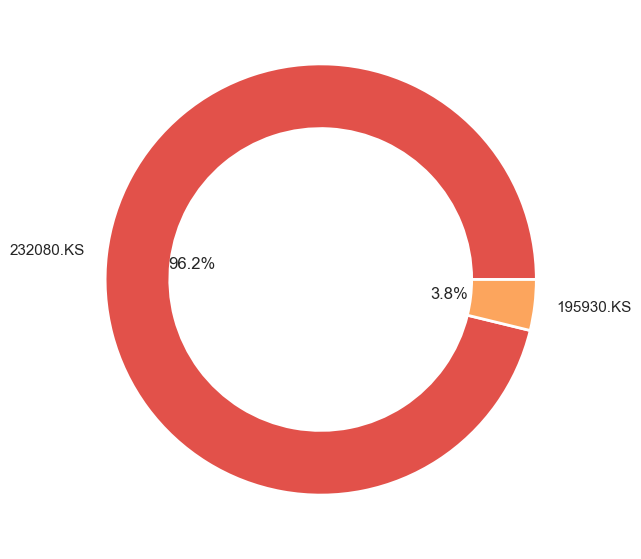

In [8]:
# 가중치 데이터프레임 생성
weights_df = pd.Series(np.round(weights, 3), index=tickers)
weights_df = weights_df[weights_df > 0.0]

# 파이차트 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

* 코스닥 

In [82]:
# MSR 모델 가중치 계산 함수
def get_msr_weights(er, cov):

    # 자산 개수
    noa = er.shape[0]

    # 초기 가중치
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 및 상하한값
    bounds = ((0.0, 1.0), ) * noa # 최대 투자 비율 100%
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수: 마이너스 샤프비율
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = minimize(neg_sharpe,
                   init_guess,
                   args=(er, cov),
                   method='SLSQP', # 복잡한 목적함수식 -> 이차식으로 근사
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)

    return res.x

In [83]:
# 최적 포트폴리오 성과 계산
def portfolio_performance(weights, returns, cov_matrix):
    port_return = np.dot(weights, returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

optimal_return, optimal_volatility = portfolio_performance(weights, er, cov)
optimal_sharpe = (optimal_return - 0.04) / optimal_volatility  # 무위험 수익률 4.5% 가정

print(f'최적 포트폴리오 예상 연간 수익률: {optimal_return:.2%}')
print(f'최적 포트폴리오 예상 연간 변동성: {optimal_volatility:.2%}')
print(f'최적 포트폴리오 샤프 비율: {optimal_sharpe:.2f}')


최적 포트폴리오 예상 연간 수익률: 17.19%
최적 포트폴리오 예상 연간 변동성: 12.50%
최적 포트폴리오 샤프 비율: 1.06


* 샤프비율 해석: 일반적으로 샤프비율이 1 이상이면 좋은 것으로 간주되고, 2 이상이면 우수한 것으로 간주

In [84]:
# 빈 데이터프레임 생성
msr_w_df = pd.DataFrame().reindex_like(rets)

# 기대수익률 배열
er = np.array(rets * 12)
print(er.shape)

# 공분산행렬 배열 (롤링 공분산 계산)
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])
print(cov.shape)

# MSR 가중치 계산 
for i in range(12, len(msr_w_df)):
    msr_w_df.iloc[i] = get_msr_weights(er[i-1], cov[i-1])

(52, 6)
(52, 6, 6)


In [85]:
msr_w_df

,069500.KS,143850.KS,192090.KS,195930.KS,232080.KS,271050.KS
Date,,,,,,
2023-06-25,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-02,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-09,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-23,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-30,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-06,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-13,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-20,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

# 현재 작업 디렉토리에 'msr_weights.csv'로 저장
msr_w_df.to_csv('msr_weight.csv', index=True)

### 샤프비율 최대화 포트폴리오 시계열 가중치 플랏 생성

Text(0, 0.5, 'Weights')

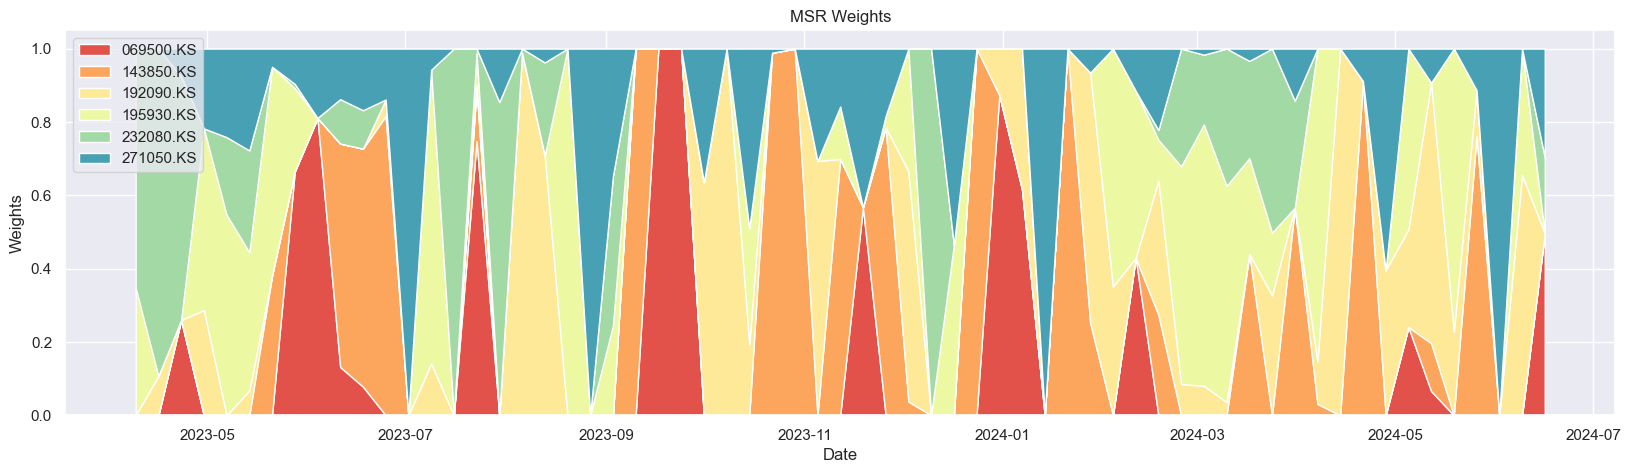

In [ ]:
# 가중치 시계열 시각화
plt.figure(figsize=(20, 5))
plt.stackplot(msr_w_df.index, msr_w_df.T, labels=msr_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('MSR Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

### 샤프비율 최대화 포트폴리오 백테스팅 결과
* 크게 의미 없다고 판단

Text(0, 0.5, 'Returns')

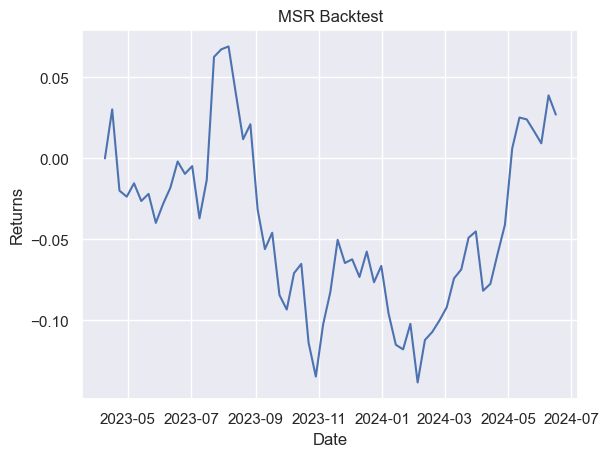

In [ ]:
# 포트폴리오 수익률 데이터프레임
port_rets = msr_w_df.shift() * rets
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1 # 복리수익률

# MSR 백테스팅 시각화
plt.plot(port_cum_rets.iloc[12:])
plt.title('MSR Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')

* 6월 14일 시 코스닥 150 1.4% 하락
* 샤프비율에는 몇 가지 제한사항이 있다.... 예를 들어, 투자 수익이 정규 분포를 따른다고 가정하지만 항상 그렇지 않을 수도 있음 또한 이 비율은 투자 성과에 큰 영향을 미칠 수 있는 시장 상황의 변화를 고려하지 않아서 
* 거시경제도 함께 파악 필요

* 샤프비율 최대화 특징 중 코너해 발생으로 인해 절대적 지표로 사용하기 어렵다